In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import SGD

In [3]:
df_train = pd.read_csv('train.csv', index_col='Date', parse_dates=['Date'])
df_test = pd.read_csv('test.csv', index_col='Date', parse_dates=['Date'])

In [4]:
df = pd.concat([df_train, df_test])

In [5]:
print(df['Adj Close'].describe())

count    1042.000000
mean     1440.785029
std       237.312609
min      1160.400024
25%      1266.099976
50%      1319.799988
75%      1577.949951
max      2051.500000
Name: Adj Close, dtype: float64


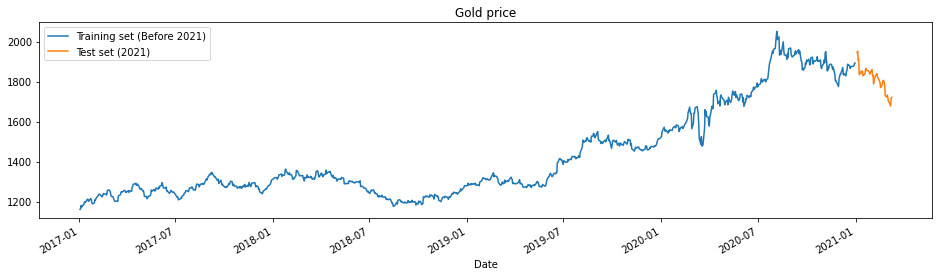

In [6]:
df_train["Adj Close"].plot(figsize=(16,4),legend=True)
df_test["Adj Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2021)','Test set (2021)'])
plt.title('Gold price')
plt.show()

In [7]:
df_train["Adj Close Log"] = df_train.apply(lambda x: np.log(x["Adj Close"]), axis = 1)

In [8]:
df_test["Adj Close Log"] = df_test.apply(lambda x: np.log(x["Adj Close"]), axis = 1)

In [9]:
training_set = df_train.iloc[:,6:7].values
testing_set = df_test.iloc[:,6:7].values

In [10]:
# Scaling the dataset
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

In [11]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Actual Gold Price')
    plt.plot(predicted, color='blue',label='Predicted Gold Price')
    plt.title('Gold Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Gold Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae = mean_absolute_error(test, predicted)
    rmse = mean_squared_error(test, predicted, squared= False)
    print("Mean absolute error, MAE = {}".format(mae))
    print("Root mean squared error, RMSE = {}".format(rmse))

def cal_X_y(dataset, h_id):
    X, y = [], []
    for i in range(h_id,len(dataset)-h_id):
        X.append(dataset[i-h_id:i,0])
        y.append(dataset[i,0])
    X, y = np.array(X), np.array(y)
    return X,y

# Model Predictions for Forecasting Horizon = 4 days

In [12]:
# Forecasting Horizon = 4 days
X_train, y_train = cal_X_y(training_set_scaled, 4)
X_test, y_test = cal_X_y(testing_set_scaled, 4)

In [13]:
X_train[:5]

array([[0.        , 0.00513466, 0.02894901, 0.01730691],
       [0.00513466, 0.02894901, 0.01730691, 0.03459307],
       [0.02894901, 0.01730691, 0.03459307, 0.03563071],
       [0.01730691, 0.03459307, 0.03563071, 0.05244472],
       [0.03459307, 0.03563071, 0.05244472, 0.05728208]])

In [14]:
y_train[:5]

array([0.03459307, 0.03563071, 0.05244472, 0.05728208, 0.05200441])

In [15]:
X_train.shape

(988, 4)

In [16]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [17]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [18]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 4

In [19]:
# CNN-LSTM-1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 4, 32)       96        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 4, 64)       4160      
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 95,957
Trainable params: 95,957
Non-trainable params: 0
____________________________________________________

In [20]:
model1.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 25ms/step - loss: 0.1236
Epoch 2/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0258
Epoch 3/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0154
Epoch 4/250
8/8 [==============================] - 0s 17ms/step - loss: 0.0055
Epoch 5/250
8/8 [==============================] - 0s 25ms/step - loss: 0.0048
Epoch 6/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0017
Epoch 7/250
8/8 [==============================] - 0s 22ms/step - loss: 9.4606e-04
Epoch 8/250
8/8 [==============================] - 0s 21ms/step - loss: 5.7039e-04
Epoch 9/250
8/8 [==============================] - 0s 19ms/step - loss: 4.7261e-04
Epoch 10/250
8/8 [==============================] - 0s 17ms/step - loss: 4.5154e-04
Epoch 11/250
8/8 [==============================] - 0s 25ms/step - loss: 4.2397e-04
Epoch 12/250
8/8 [==============================] - 0s 20ms/step - loss: 3.9646e-04
Epoch 13/250
8/8 [=======

8/8 [==============================] - 0s 17ms/step - loss: 2.6555e-04
Epoch 99/250
8/8 [==============================] - 0s 16ms/step - loss: 2.7313e-04
Epoch 100/250
8/8 [==============================] - 0s 17ms/step - loss: 2.7860e-04
Epoch 101/250
8/8 [==============================] - 0s 26ms/step - loss: 2.6963e-04
Epoch 102/250
8/8 [==============================] - 0s 24ms/step - loss: 2.7817e-04
Epoch 103/250
8/8 [==============================] - 0s 26ms/step - loss: 2.9977e-04
Epoch 104/250
8/8 [==============================] - 0s 15ms/step - loss: 3.1297e-04
Epoch 105/250
8/8 [==============================] - 0s 15ms/step - loss: 2.8871e-04
Epoch 106/250
8/8 [==============================] - 0s 14ms/step - loss: 2.9049e-04
Epoch 107/250
8/8 [==============================] - 0s 14ms/step - loss: 2.7305e-04
Epoch 108/250
8/8 [==============================] - 0s 15ms/step - loss: 2.7917e-04
Epoch 109/250
8/8 [==============================] - 0s 22ms/step - loss: 2.6858

8/8 [==============================] - 0s 24ms/step - loss: 3.0340e-04
Epoch 195/250
8/8 [==============================] - 0s 16ms/step - loss: 2.6452e-04
Epoch 196/250
8/8 [==============================] - 0s 23ms/step - loss: 2.8477e-04
Epoch 197/250
8/8 [==============================] - 0s 14ms/step - loss: 2.7690e-04
Epoch 198/250
8/8 [==============================] - 0s 14ms/step - loss: 2.6110e-04
Epoch 199/250
8/8 [==============================] - 0s 15ms/step - loss: 2.6138e-04
Epoch 200/250
8/8 [==============================] - 0s 15ms/step - loss: 2.5931e-04
Epoch 201/250
8/8 [==============================] - 0s 20ms/step - loss: 2.7677e-04
Epoch 202/250
8/8 [==============================] - 0s 15ms/step - loss: 2.7924e-04
Epoch 203/250
8/8 [==============================] - 0s 22ms/step - loss: 3.0140e-04
Epoch 204/250
8/8 [==============================] - 0s 22ms/step - loss: 3.1192e-04
Epoch 205/250
8/8 [==============================] - 0s 18ms/step - loss: 2.790

In [21]:
predicted_y_test = model1.predict(X_test_re)

## Results of CNN-LSTM-1 model for forecasting horizon = 4

In [22]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.02314567181440798
Root mean squared error, RMSE = 0.02936165183686157


In [23]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

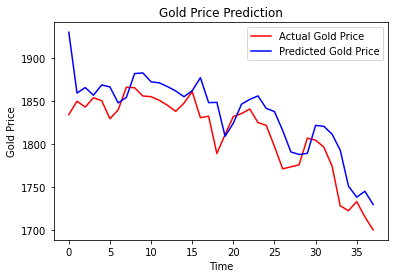

In [24]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 4

In [25]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, None, 4, 64)       192       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 4, 128)      16512     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 2, 128)      0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               365600    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [26]:
model2.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 41ms/step - loss: 0.1080
Epoch 2/250
8/8 [==============================] - 0s 41ms/step - loss: 0.0202
Epoch 3/250
8/8 [==============================] - 0s 38ms/step - loss: 0.0081
Epoch 4/250
8/8 [==============================] - 0s 53ms/step - loss: 0.0057
Epoch 5/250
8/8 [==============================] - 0s 42ms/step - loss: 0.0019
Epoch 6/250
8/8 [==============================] - 0s 35ms/step - loss: 8.4546e-04
Epoch 7/250
8/8 [==============================] - 0s 35ms/step - loss: 5.3649e-04
Epoch 8/250
8/8 [==============================] - 0s 39ms/step - loss: 4.4042e-04
Epoch 9/250
8/8 [==============================] - 0s 37ms/step - loss: 4.1715e-04
Epoch 10/250
8/8 [==============================] - 0s 33ms/step - loss: 4.0994e-04
Epoch 11/250
8/8 [==============================] - 0s 48ms/step - loss: 3.8241e-04
Epoch 12/250
8/8 [==============================] - 0s 39ms/step - loss: 3.7723e-04
Epoch 13/250
8/8 [===

8/8 [==============================] - 0s 33ms/step - loss: 2.5605e-04
Epoch 99/250
8/8 [==============================] - 0s 33ms/step - loss: 2.6311e-04
Epoch 100/250
8/8 [==============================] - 0s 34ms/step - loss: 2.6936e-04
Epoch 101/250
8/8 [==============================] - 0s 33ms/step - loss: 2.6326e-04
Epoch 102/250
8/8 [==============================] - 0s 32ms/step - loss: 2.5613e-04
Epoch 103/250
8/8 [==============================] - 0s 32ms/step - loss: 2.5742e-04
Epoch 104/250
8/8 [==============================] - 0s 31ms/step - loss: 2.6345e-04
Epoch 105/250
8/8 [==============================] - 0s 34ms/step - loss: 2.5556e-04
Epoch 106/250
8/8 [==============================] - 0s 43ms/step - loss: 2.8740e-04
Epoch 107/250
8/8 [==============================] - 0s 43ms/step - loss: 2.6913e-04
Epoch 108/250
8/8 [==============================] - 0s 48ms/step - loss: 2.6401e-04
Epoch 109/250
8/8 [==============================] - 0s 48ms/step - loss: 2.8164

8/8 [==============================] - 0s 51ms/step - loss: 3.0587e-04
Epoch 195/250
8/8 [==============================] - 0s 50ms/step - loss: 2.9356e-04
Epoch 196/250
8/8 [==============================] - 0s 37ms/step - loss: 2.7665e-04
Epoch 197/250
8/8 [==============================] - 0s 33ms/step - loss: 2.6293e-04
Epoch 198/250
8/8 [==============================] - 0s 50ms/step - loss: 2.8084e-04
Epoch 199/250
8/8 [==============================] - 0s 39ms/step - loss: 2.6989e-04
Epoch 200/250
8/8 [==============================] - 0s 57ms/step - loss: 2.7193e-04
Epoch 201/250
8/8 [==============================] - 0s 36ms/step - loss: 2.7454e-04
Epoch 202/250
8/8 [==============================] - 0s 47ms/step - loss: 3.1147e-04
Epoch 203/250
8/8 [==============================] - 0s 57ms/step - loss: 2.7620e-04
Epoch 204/250
8/8 [==============================] - 0s 32ms/step - loss: 2.5954e-04
Epoch 205/250
8/8 [==============================] - 0s 32ms/step - loss: 2.506

In [27]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 4

In [28]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.01789719655071384
Root mean squared error, RMSE = 0.02464996396290193


In [29]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

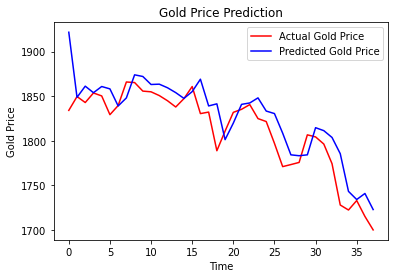

In [30]:
# Visualizing the results for CCN-LSTM-2 Model for forecasting horizon = 4
plot_predictions(y_test_real_price,predicted_y_test_real_price2)

# Model Predictions for Forecasting Horizon = 6 days

In [31]:
# Forecasting Horizon = 6 days
X_train, y_train = cal_X_y(training_set_scaled, 6)
X_test, y_test = cal_X_y(testing_set_scaled, 6)

In [32]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [33]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [34]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 6

In [35]:
# CNN-LSTM1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_8 (TimeDist (None, None, 6, 32)       96        
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 6, 64)       4160      
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 3, 64)       0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 192)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               117200    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 121,557
Trainable params: 121,557
Non-trainable params: 0
________________________________________________

In [36]:
model1.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 24ms/step - loss: 0.1071
Epoch 2/250
8/8 [==============================] - 0s 22ms/step - loss: 0.0141
Epoch 3/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0103
Epoch 4/250
8/8 [==============================] - 0s 21ms/step - loss: 0.0050
Epoch 5/250
8/8 [==============================] - 0s 19ms/step - loss: 0.0022
Epoch 6/250
8/8 [==============================] - 0s 30ms/step - loss: 0.0015
Epoch 7/250
8/8 [==============================] - 0s 23ms/step - loss: 8.5190e-04
Epoch 8/250
8/8 [==============================] - 0s 26ms/step - loss: 5.8115e-04
Epoch 9/250
8/8 [==============================] - 0s 25ms/step - loss: 5.9034e-04
Epoch 10/250
8/8 [==============================] - 0s 25ms/step - loss: 5.4971e-04
Epoch 11/250
8/8 [==============================] - 0s 22ms/step - loss: 5.3326e-04
Epoch 12/250
8/8 [==============================] - 0s 31ms/step - loss: 5.1445e-04
Epoch 13/250
8/8 [=======

8/8 [==============================] - 0s 21ms/step - loss: 3.0851e-04
Epoch 99/250
8/8 [==============================] - 0s 17ms/step - loss: 3.1373e-04
Epoch 100/250
8/8 [==============================] - 0s 16ms/step - loss: 3.0424e-04
Epoch 101/250
8/8 [==============================] - 0s 16ms/step - loss: 3.1059e-04
Epoch 102/250
8/8 [==============================] - 0s 28ms/step - loss: 3.0680e-04
Epoch 103/250
8/8 [==============================] - 0s 32ms/step - loss: 3.0277e-04
Epoch 104/250
8/8 [==============================] - 0s 32ms/step - loss: 3.0498e-04
Epoch 105/250
8/8 [==============================] - 0s 21ms/step - loss: 2.9315e-04
Epoch 106/250
8/8 [==============================] - 0s 24ms/step - loss: 2.8586e-04
Epoch 107/250
8/8 [==============================] - 0s 30ms/step - loss: 2.8443e-04
Epoch 108/250
8/8 [==============================] - 0s 31ms/step - loss: 2.8591e-04
Epoch 109/250
8/8 [==============================] - 0s 17ms/step - loss: 2.8856

8/8 [==============================] - 0s 19ms/step - loss: 2.5734e-04
Epoch 195/250
8/8 [==============================] - 0s 17ms/step - loss: 2.5738e-04
Epoch 196/250
8/8 [==============================] - 0s 18ms/step - loss: 2.7177e-04
Epoch 197/250
8/8 [==============================] - 0s 17ms/step - loss: 2.7441e-04
Epoch 198/250
8/8 [==============================] - 0s 28ms/step - loss: 2.5960e-04
Epoch 199/250
8/8 [==============================] - 0s 26ms/step - loss: 2.5493e-04
Epoch 200/250
8/8 [==============================] - 0s 19ms/step - loss: 2.6681e-04
Epoch 201/250
8/8 [==============================] - 0s 18ms/step - loss: 2.7482e-04
Epoch 202/250
8/8 [==============================] - 0s 16ms/step - loss: 2.6100e-04
Epoch 203/250
8/8 [==============================] - 0s 19ms/step - loss: 2.5246e-04
Epoch 204/250
8/8 [==============================] - 0s 18ms/step - loss: 2.5154e-04
Epoch 205/250
8/8 [==============================] - 0s 17ms/step - loss: 2.643

In [37]:
predicted_y_test = model1.predict(X_test_re)

### Results of CNN-LSTM-1 model for forecasting horizon = 6

In [38]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.012739151456263939
Root mean squared error, RMSE = 0.0176341364817855


In [39]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

In [40]:
return_rmse(y_test_real_price,predicted_y_test_real_price)

Mean absolute error, MAE = 13.124770220588221
Root mean squared error, RMSE = 18.092113848345576


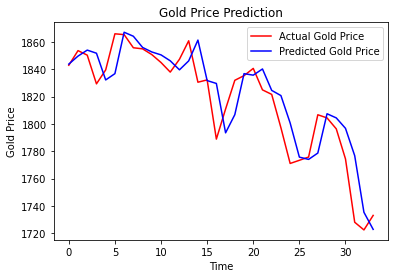

In [41]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 6

In [42]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 6, 64)       192       
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 6, 128)      16512     
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 3, 128)      0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 384)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               468000    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [43]:
model2.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 50ms/step - loss: 0.1014
Epoch 2/250
8/8 [==============================] - 0s 57ms/step - loss: 0.0175
Epoch 3/250
8/8 [==============================] - 0s 60ms/step - loss: 0.0085
Epoch 4/250
8/8 [==============================] - 0s 53ms/step - loss: 0.0045
Epoch 5/250
8/8 [==============================] - 0s 49ms/step - loss: 0.0023
Epoch 6/250
8/8 [==============================] - 0s 44ms/step - loss: 0.0012
Epoch 7/250
8/8 [==============================] - 0s 46ms/step - loss: 7.2301e-04
Epoch 8/250
8/8 [==============================] - 0s 45ms/step - loss: 5.8336e-04
Epoch 9/250
8/8 [==============================] - 0s 48ms/step - loss: 5.1103e-04
Epoch 10/250
8/8 [==============================] - 0s 44ms/step - loss: 4.9047e-04
Epoch 11/250
8/8 [==============================] - 0s 46ms/step - loss: 4.8297e-04
Epoch 12/250
8/8 [==============================] - 0s 45ms/step - loss: 4.7420e-04
Epoch 13/250
8/8 [=======

8/8 [==============================] - 0s 43ms/step - loss: 3.5706e-04
Epoch 99/250
8/8 [==============================] - 0s 42ms/step - loss: 3.0404e-04
Epoch 100/250
8/8 [==============================] - 0s 41ms/step - loss: 3.4269e-04
Epoch 101/250
8/8 [==============================] - 0s 56ms/step - loss: 3.2130e-04
Epoch 102/250
8/8 [==============================] - 0s 53ms/step - loss: 2.7991e-04
Epoch 103/250
8/8 [==============================] - 1s 66ms/step - loss: 2.9494e-04
Epoch 104/250
8/8 [==============================] - 0s 42ms/step - loss: 2.7944e-04
Epoch 105/250
8/8 [==============================] - 0s 44ms/step - loss: 2.6467e-04
Epoch 106/250
8/8 [==============================] - 0s 47ms/step - loss: 2.8264e-04
Epoch 107/250
8/8 [==============================] - 1s 64ms/step - loss: 3.1769e-04
Epoch 108/250
8/8 [==============================] - 0s 42ms/step - loss: 2.8679e-04
Epoch 109/250
8/8 [==============================] - 0s 41ms/step - loss: 2.8384

8/8 [==============================] - 0s 55ms/step - loss: 2.6688e-04
Epoch 195/250
8/8 [==============================] - 0s 50ms/step - loss: 2.5867e-04
Epoch 196/250
8/8 [==============================] - 0s 40ms/step - loss: 2.8524e-04
Epoch 197/250
8/8 [==============================] - 0s 59ms/step - loss: 2.5603e-04
Epoch 198/250
8/8 [==============================] - 0s 57ms/step - loss: 2.6307e-04
Epoch 199/250
8/8 [==============================] - 0s 41ms/step - loss: 2.6068e-04
Epoch 200/250
8/8 [==============================] - 0s 46ms/step - loss: 2.6182e-04
Epoch 201/250
8/8 [==============================] - 0s 44ms/step - loss: 2.9559e-04
Epoch 202/250
8/8 [==============================] - 0s 42ms/step - loss: 3.5175e-04
Epoch 203/250
8/8 [==============================] - 0s 54ms/step - loss: 3.3027e-04
Epoch 204/250
8/8 [==============================] - 1s 84ms/step - loss: 3.0665e-04
Epoch 205/250
8/8 [==============================] - 1s 75ms/step - loss: 2.919

In [44]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 6

In [45]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.012820511612512905
Root mean squared error, RMSE = 0.017402200532586072


In [46]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

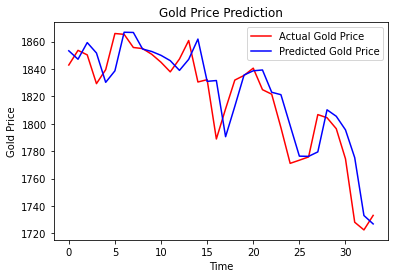

In [47]:
# Visualizing the results for CCN-LSTM2 Model for forecasting horizon = 6
plot_predictions(y_test_real_price,predicted_y_test_real_price2)

# Model Predictions for Forecasting Horizon = 9 days

In [48]:
# Forecasting Horizon = 9 days
X_train, y_train = cal_X_y(training_set_scaled, 9)
X_test, y_test = cal_X_y(testing_set_scaled, 9)

In [49]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape((X_test.shape[0],X_train.shape[1],1))

In [50]:
X_train_re = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
X_test_re = X_test.reshape((X_test.shape[0],1,X_train.shape[1],1))

In [51]:
y_train = np.reshape(y_train, (y_train.shape[0],))
y_test = np.reshape(y_test, (y_test.shape[0],))

## Creating CNN-LSTM-1 Model for forecasting horizon = 9

In [52]:
# CNN-LSTM1 model
model1 = Sequential()
# define CNN model
model1.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model1.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation='relu', padding='same')))
model1.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model1.add(TimeDistributed(Flatten()))
# define LSTM model
model1.add(LSTM(units = 100))
# define the Output layer
model1.add(Dense(1))
# compile the model
model1.compile(optimizer='adam',loss='mean_squared_error')
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, None, 9, 32)       96        
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 9, 64)       4160      
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 256)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               142800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 147,157
Trainable params: 147,157
Non-trainable params: 0
________________________________________________

In [53]:
model1.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 21ms/step - loss: 0.1067
Epoch 2/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0127
Epoch 3/250
8/8 [==============================] - 0s 19ms/step - loss: 0.0079
Epoch 4/250
8/8 [==============================] - 0s 20ms/step - loss: 0.0054
Epoch 5/250
8/8 [==============================] - 0s 24ms/step - loss: 0.0020
Epoch 6/250
8/8 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 7/250
8/8 [==============================] - 0s 21ms/step - loss: 9.2020e-04
Epoch 8/250
8/8 [==============================] - 0s 18ms/step - loss: 7.8929e-04
Epoch 9/250
8/8 [==============================] - 0s 23ms/step - loss: 7.7533e-04
Epoch 10/250
8/8 [==============================] - 0s 27ms/step - loss: 7.4027e-04
Epoch 11/250
8/8 [==============================] - 0s 23ms/step - loss: 7.1698e-04
Epoch 12/250
8/8 [==============================] - 0s 21ms/step - loss: 7.1237e-04
Epoch 13/250
8/8 [=======

8/8 [==============================] - 0s 25ms/step - loss: 2.8513e-04
Epoch 99/250
8/8 [==============================] - 0s 21ms/step - loss: 2.7754e-04
Epoch 100/250
8/8 [==============================] - 0s 18ms/step - loss: 2.9461e-04
Epoch 101/250
8/8 [==============================] - 0s 18ms/step - loss: 2.9575e-04
Epoch 102/250
8/8 [==============================] - 0s 19ms/step - loss: 2.8634e-04
Epoch 103/250
8/8 [==============================] - 0s 19ms/step - loss: 2.7159e-04
Epoch 104/250
8/8 [==============================] - 0s 19ms/step - loss: 2.7862e-04
Epoch 105/250
8/8 [==============================] - 0s 24ms/step - loss: 2.8580e-04
Epoch 106/250
8/8 [==============================] - 0s 20ms/step - loss: 2.8297e-04
Epoch 107/250
8/8 [==============================] - 0s 19ms/step - loss: 2.8988e-04
Epoch 108/250
8/8 [==============================] - 0s 20ms/step - loss: 2.8153e-04
Epoch 109/250
8/8 [==============================] - 0s 18ms/step - loss: 2.7290

8/8 [==============================] - 0s 31ms/step - loss: 2.8469e-04
Epoch 195/250
8/8 [==============================] - 0s 31ms/step - loss: 2.9388e-04
Epoch 196/250
8/8 [==============================] - 0s 29ms/step - loss: 3.1486e-04
Epoch 197/250
8/8 [==============================] - 0s 29ms/step - loss: 2.6634e-04
Epoch 198/250
8/8 [==============================] - 0s 30ms/step - loss: 2.8456e-04
Epoch 199/250
8/8 [==============================] - 0s 31ms/step - loss: 2.8261e-04
Epoch 200/250
8/8 [==============================] - 0s 34ms/step - loss: 2.5641e-04
Epoch 201/250
8/8 [==============================] - 0s 38ms/step - loss: 2.6070e-04
Epoch 202/250
8/8 [==============================] - 0s 27ms/step - loss: 2.5940e-04
Epoch 203/250
8/8 [==============================] - 0s 32ms/step - loss: 2.6004e-04
Epoch 204/250
8/8 [==============================] - 0s 30ms/step - loss: 2.9250e-04
Epoch 205/250
8/8 [==============================] - 0s 35ms/step - loss: 3.109

In [54]:
predicted_y_test = model1.predict(X_test_re)

### Results of CNN-LSTM-1 model for forecasting horizon = 9

In [55]:
return_rmse(y_test,predicted_y_test)

Mean absolute error, MAE = 0.013600571222515092
Root mean squared error, RMSE = 0.01769954172425755


In [56]:
predicted_y_test_real_price = np.exp(sc.inverse_transform(predicted_y_test))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

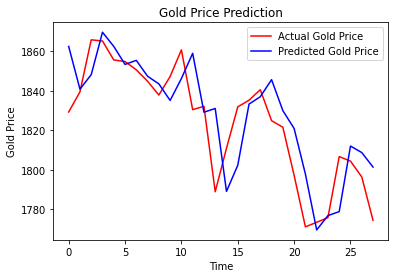

In [57]:
# Visualizing the results for CCN-LSTM-1 Model for forecasting horizon = 9
plot_predictions(y_test_real_price,predicted_y_test_real_price)

## Creating CNN-LSTM-2 Model for forecasting horizon = 9

In [58]:
# CNN-LSTM-2 model
model2 = Sequential()
# define CNN model
model2.add(TimeDistributed(Conv1D(filters = 64, kernel_size = 2, activation = 'relu', padding='same'), input_shape = (None,X_train_re.shape[2],1)))
model2.add(TimeDistributed(Conv1D(filters = 128, kernel_size = 2, activation='relu', padding='same')))
model2.add(TimeDistributed(MaxPooling1D(pool_size = 2)))
model2.add(TimeDistributed(Flatten()))
# define LSTM model
model2.add(LSTM(units = 200))
# define Fully-connected layer
model2.add(Dense(32, activation='relu'))
# define Output layer
model2.add(Dense(1))
# compile the model
model2.compile(optimizer='adam',loss='mean_squared_error')
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, None, 9, 64)       192       
_________________________________________________________________
time_distributed_21 (TimeDis (None, None, 9, 128)      16512     
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 4, 128)      0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 512)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 200)               570400    
_________________________________________________________________
dense_7 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [59]:
model2.fit(X_train_re, y_train, epochs=250, batch_size=128, verbose=True)

Epoch 1/250
8/8 [==============================] - 0s 59ms/step - loss: 0.0668
Epoch 2/250
8/8 [==============================] - 1s 63ms/step - loss: 0.0163
Epoch 3/250
8/8 [==============================] - 0s 53ms/step - loss: 0.0094
Epoch 4/250
8/8 [==============================] - 0s 54ms/step - loss: 0.0030
Epoch 5/250
8/8 [==============================] - 1s 65ms/step - loss: 0.0017
Epoch 6/250
8/8 [==============================] - 1s 64ms/step - loss: 0.0011
Epoch 7/250
8/8 [==============================] - 0s 50ms/step - loss: 9.0190e-04
Epoch 8/250
8/8 [==============================] - 0s 55ms/step - loss: 7.8002e-04
Epoch 9/250
8/8 [==============================] - 0s 51ms/step - loss: 7.4487e-04
Epoch 10/250
8/8 [==============================] - 0s 51ms/step - loss: 7.0384e-04
Epoch 11/250
8/8 [==============================] - 0s 51ms/step - loss: 6.9454e-04
Epoch 12/250
8/8 [==============================] - 0s 52ms/step - loss: 6.8277e-04
Epoch 13/250
8/8 [=======

8/8 [==============================] - 1s 87ms/step - loss: 2.6065e-04
Epoch 99/250
8/8 [==============================] - 1s 68ms/step - loss: 2.7112e-04
Epoch 100/250
8/8 [==============================] - 1s 95ms/step - loss: 2.5879e-04
Epoch 101/250
8/8 [==============================] - 1s 70ms/step - loss: 2.9196e-04
Epoch 102/250
8/8 [==============================] - 1s 78ms/step - loss: 3.1532e-04
Epoch 103/250
8/8 [==============================] - 1s 95ms/step - loss: 3.0338e-04
Epoch 104/250
8/8 [==============================] - 1s 92ms/step - loss: 2.8387e-04
Epoch 105/250
8/8 [==============================] - 1s 82ms/step - loss: 2.4981e-04
Epoch 106/250
8/8 [==============================] - 1s 82ms/step - loss: 2.6123e-04
Epoch 107/250
8/8 [==============================] - 1s 65ms/step - loss: 2.5752e-04
Epoch 108/250
8/8 [==============================] - 1s 73ms/step - loss: 2.4613e-04
Epoch 109/250
8/8 [==============================] - 1s 75ms/step - loss: 2.4750

8/8 [==============================] - 1s 87ms/step - loss: 3.1330e-04
Epoch 195/250
8/8 [==============================] - 1s 71ms/step - loss: 3.3067e-04
Epoch 196/250
8/8 [==============================] - 1s 73ms/step - loss: 2.7833e-04
Epoch 197/250
8/8 [==============================] - 1s 68ms/step - loss: 2.5356e-04
Epoch 198/250
8/8 [==============================] - 1s 67ms/step - loss: 2.6210e-04
Epoch 199/250
8/8 [==============================] - 1s 64ms/step - loss: 2.6615e-04
Epoch 200/250
8/8 [==============================] - 0s 62ms/step - loss: 2.5183e-04
Epoch 201/250
8/8 [==============================] - 1s 69ms/step - loss: 2.5928e-04
Epoch 202/250
8/8 [==============================] - 0s 58ms/step - loss: 2.4028e-04
Epoch 203/250
8/8 [==============================] - 0s 57ms/step - loss: 2.5291e-04
Epoch 204/250
8/8 [==============================] - 1s 72ms/step - loss: 2.4766e-04
Epoch 205/250
8/8 [==============================] - 0s 62ms/step - loss: 2.408

In [60]:
predicted_y_test2 = model2.predict(X_test_re)

## Results of CNN-LSTM-2 model for forecasting horizon = 9

In [61]:
return_rmse(y_test,predicted_y_test2)

Mean absolute error, MAE = 0.016655090805468058
Root mean squared error, RMSE = 0.020549860365494648


In [62]:
predicted_y_test_real_price2 = np.exp(sc.inverse_transform(predicted_y_test2))
y_test_real_price = np.exp(sc.inverse_transform(y_test.reshape(-1,1)))

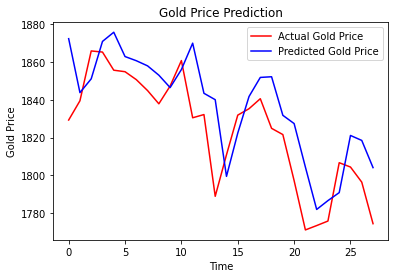

In [63]:
# Visualizing the results for CCN-LSTM2 Model for forecasting horizon = 9
plot_predictions(y_test_real_price,predicted_y_test_real_price2)